# **ArtistGAN**
- Author: Rahul Golder

## **Importing Libraries**

### **Kaggle Setup**

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

## Upload the Kaggle API file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahulgolder","key":"a37a466559da6751214741b9112011d3"}'}

In [ ]:
## make a kaggle Directory
! mkdir ~/.kaggle

## Copy Kaggle JSON file to kaggle Directory
! cp kaggle.json ~/.kaggle/

In [ ]:
## Changing Permission of The File
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
## List of Datasets
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           5491        173  1.0              
surajjha101/stores-area-and-sales-data                                Supermarket store branches sales analysis            10KB  2022-04-29 11:10:16           5019        151  1.0              
devansodariya/student-performance-data                                Student Performance Dataset                           7KB  2022-05-26 13:55:09           1922        105  0.9705882        
paradisejoy/top-hits-spotify-f

In [ ]:
## Download Dataset from Kaggle

! kaggle competitions download -c gan-getting-started
! kaggle datasets download -d rahulgolder/cyclegan-training-weights

 98% 361M/367M [00:04<00:00, 107MB/s]
100% 367M/367M [00:04<00:00, 91.4MB/s]
 94% 281M/298M [00:03<00:00, 76.3MB/s]
100% 298M/298M [00:03<00:00, 102MB/s] 


In [ ]:
## Creating a Data Directory

! mkdir data

In [ ]:
## Unzipping the Downloaded data

! unzip gan-getting-started.zip -d data
! unzip cyclegan-training-weights.zip -d data

### **System and Utility Library and Extensions**

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import time
import itertools
import random
from glob import glob
import shutil
from tqdm.notebook import tqdm

### **Data Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
from PIL import Image

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics



### **Deep Modelling Library**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

## **System Management**

### **Directory Management**

In [ ]:
os.makedirs('Saved_Models', exist_ok = True)
os.makedirs('Results', exist_ok = True)

### **Seed Setting**

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(1003)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Data Import**

### **Image Dataset Class**

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return photo_img, monet_img

    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

data = ImageDataset('/content/data/monet_jpg', '/content/data/photo_jpg')


In [ ]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.photo_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img

    def __len__(self):
        return len(self.photo_idx.keys())

photo_data = PhotoDataset('/content/data/photo_jpg')


In [ ]:
class PaintingDataset(Dataset):
    def __init__(self, monet_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.monet_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return monet_img

    def __len__(self):
        return len(self.monet_idx.keys())

monet_data = PaintingDataset('/content/data/monet_jpg')


### **Loading Data**

In [ ]:
def load_data(data):
    data_loaded = DataLoader(data, batch_size=1, pin_memory=True, shuffle = True)
    return data_loaded
data_loaded = load_data(data)

In [ ]:
monet_data_loaded = load_data(monet_data)
photo_data_loaded = load_data(photo_data)


### **Visual Utilities**

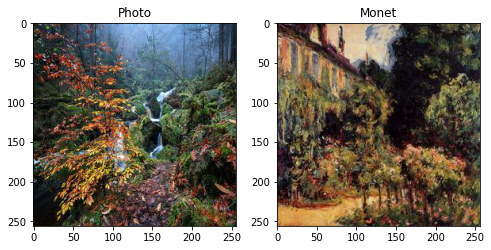

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

    
    
def show_example(data_loaded):
    photo_img, monet_img = next(iter(data_loaded))

    def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(s)

        return img
    f = plt.figure(figsize=(8, 8))

    f.add_subplot(1, 2, 1)
    plt.title('Photo')
    photo_img = unnorm(photo_img)
    plt.imshow(photo_img[0].permute(1, 2, 0))

    f.add_subplot(1, 2, 2)
    plt.title('Monet')
    monet_img = unnorm(monet_img)
    plt.imshow(monet_img[0].permute(1, 2, 0))
    
show_example(data_loaded)

## **Model Architecture Layers**

### **Residual Block**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

### **Contracting Block**

In [ ]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

### **Expanding Block**

In [ ]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

### **Feature Mapping Block**

In [ ]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        x = self.conv(x)
        return x

## **Model Architecture(Generator and Discriminator)**

### **Generator Architecture**

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

### **Discriminator Architecture**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

## **Loss Analysis**

### **Discriminator Loss**

In [ ]:
## Loss:
## Discriminator Loss

def get_discriminator_loss(real_x, fake_x, disc_X, adversarial_criterion):
    real_y = disc_X(real_x.detach())
    real_pred_y = torch.ones_like(real_y)
    fake_y = disc_X(fake_x.detach())
    fake_pred_y = torch.zeros_like(fake_y)
    real_pred_loss = adversarial_criterion(real_y, real_pred_y)
    fake_pred_loss = adversarial_criterion(fake_y, fake_pred_y)
    disc_loss = (real_pred_loss + fake_pred_loss) / 2.0
    return disc_loss
    

### **Generator Loss - Adversarial Loss**

In [ ]:
## Loss: Generator_loss - Adversarial_loss
def get_generator_adversarial_loss(real_x, gen_XY, disc_X, gen_adv_criterion):
    fake_y = gen_XY(real_x)
    fake_pred_y = disc_X(fake_y)
    gen_adv_loss = gen_adv_criterion(fake_pred_y, torch.ones_like(fake_pred_y))
    return gen_adv_loss, fake_y


### **Generator Loss - Cycle Consistency Loss**

In [ ]:
## Loss: Generator_loss - Cycle_Consistency_Loss
def get_cycle_consistency_loss(real_x, fake_y, gen_YX, cycle_criterion):
    real_pred_x = gen_YX(fake_y)
    cycle_consistency_loss = cycle_criterion(real_x, real_pred_x)
    return cycle_consistency_loss, real_pred_x
    

### **Generator Loss - Identity Loss**

In [ ]:
## Loss: Generator_loss - Identity_Loss

def get_identity_loss(real_x, gen_YX, identity_criterion):
    identity_x = gen_YX(real_x)
    identity_loss = identity_criterion(real_x, identity_x)
    return identity_loss, identity_x


### **Generator Loss Overall**

In [ ]:
## Loss: Generator_loss

def get_generator_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adversarial_criterion, cycle_criterion, identity_criterion, lambda_adversarial = 1, lambda_cycle = 9, lambda_identity = 2.10
                      ):
    adversarial_loss_AB, fake_B = get_generator_adversarial_loss(real_A, gen_AB, disc_A, adversarial_criterion)
    adversarial_loss_BA, fake_A = get_generator_adversarial_loss(real_B, gen_BA, disc_B, adversarial_criterion)
    adversarial_loss = (adversarial_loss_AB + adversarial_loss_BA)
    
    cycle_loss_ABA, real_pred_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_BAB, real_pred_B = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss = cycle_loss_ABA + cycle_loss_BAB
    
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    identity_loss = identity_loss_A + identity_loss_B
    
    generator_loss = adversarial_loss * lambda_adversarial + cycle_loss * lambda_cycle + identity_loss * lambda_identity
    return generator_loss, fake_A, fake_B
    

## **Training**

### **Parameters for Training**

In [ ]:
adversarial_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

EPOCHS = 3
dim_A = 3
dim_B = 3
DISPLAY_STEP = 200
BATCH_SIZE = 1
learning_rate = 0.000197
target_shape = 256
device = 'cuda'

### **Weights Analysis**

In [ ]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=learning_rate, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=learning_rate, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [ ]:
pretrained = True # False if training from scratch
if pretrained:
    pre_dict = torch.load("/content/data/cycleGAN_14800.pth") ## Give the path of the presaved file
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)

### **Model Training**

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.024979002475738525, Discriminator loss: 3.227628068998456e-05


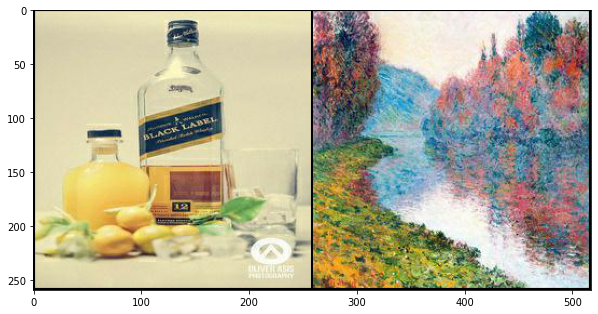

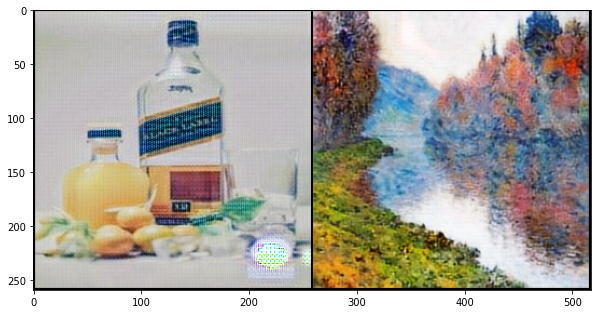

Epoch 0: Step 200: Generator (U-Net) loss: 3.0717557239532476, Discriminator loss: 0.0500946733611636


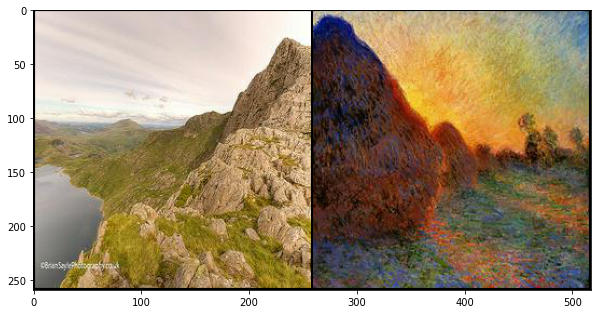

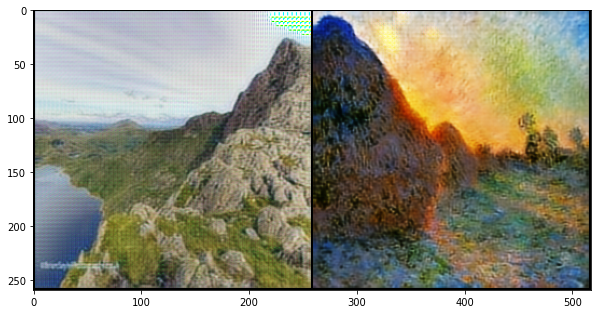

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Step 400: Generator (U-Net) loss: 2.884701234102248, Discriminator loss: 0.010102221862762235


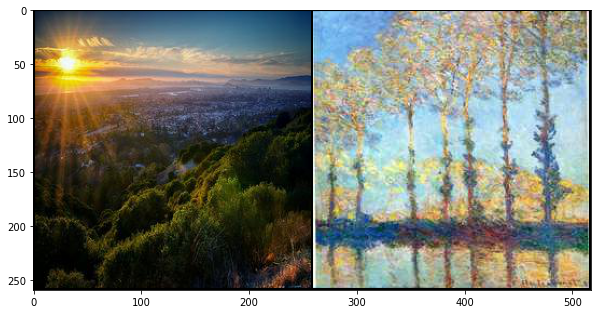

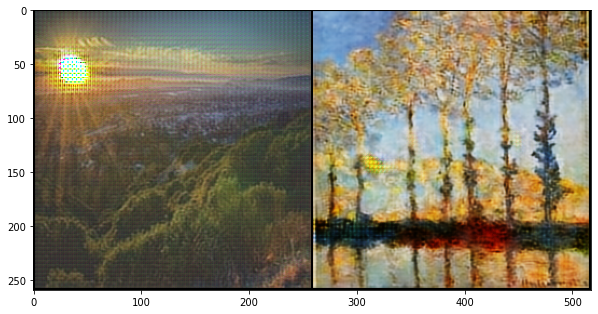

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2: Step 600: Generator (U-Net) loss: 2.6918363922834403, Discriminator loss: 0.018069649622775623


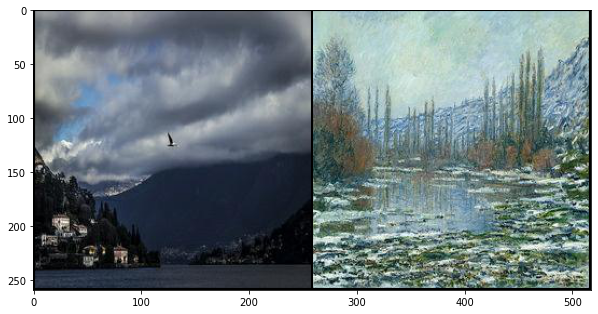

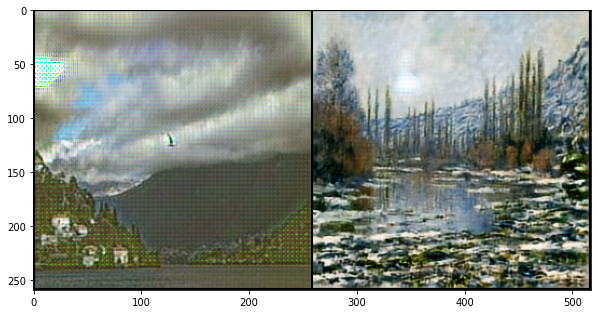

Epoch 2: Step 800: Generator (U-Net) loss: 2.696166946291924, Discriminator loss: 0.0076354618527693634


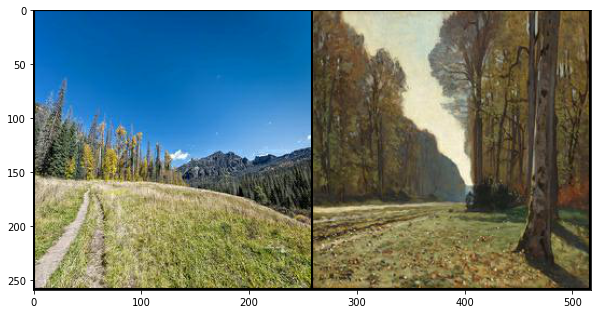

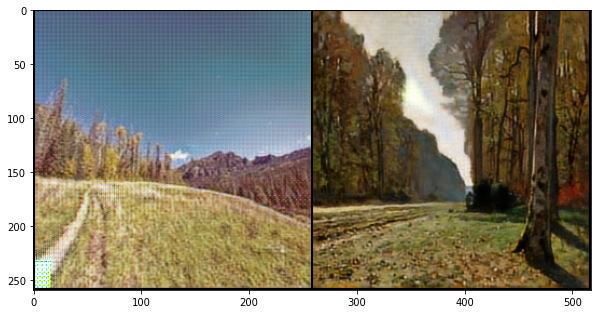

In [ ]:
## Training
from skimage import color
plt.rcParams['figure.figsize'] = [10, 10]

def train(do_save_model = False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = data_loaded
    current_step = 0
    
    for epoch in range(EPOCHS):
        if epoch == (EPOCHS - 1):
            do_save_model = True
            
        for real_A, real_B in tqdm(dataloader):
            curr_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)
            
            disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_discriminator_loss(real_A, fake_A, disc_A, adversarial_criterion)
            disc_A_loss.backward(retain_graph = True)
            disc_A_opt.step()
            
            disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_discriminator_loss(real_B, fake_B, disc_B, adversarial_criterion)
            disc_B_loss.backward(retain_graph = True)
            disc_B_opt.step()
            
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_generator_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adversarial_criterion, recon_criterion, recon_criterion)
            gen_loss.backward(retain_graph = True)
            gen_opt.step()
            
            mean_discriminator_loss += disc_A_loss.item() / DISPLAY_STEP
            mean_generator_loss += gen_loss.item() / DISPLAY_STEP
            
            ## Code for Visualization
            if current_step % DISPLAY_STEP == 0:
                print(f"Epoch {epoch}: Step {current_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if do_save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{current_step}.pth")
            current_step += 1
    return gen_AB, gen_BA
            
            
generator_real_to_painter, generator_painter_to_real = train()

#### **Super-Resolution Function**

In [ ]:
!pip install opencv-contrib-python --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66.7 MB 28 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import cv2
print("Version of OpenCV: ", cv2.__version__)

def super_res(img):
    # img = cv2.imread(img_path)
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    path = "Saved_Models/EDSR_x2.pb"
    sr.readModel(path)
    sr.setModel("edsr",2)
    result = sr.upsample(img)
    resized = cv2.resize(img,dsize=None,fx=2,fy=2)
    return resized


Version of OpenCV:  4.5.5


In [ ]:
def get_submission(do_superres = False):
    data_loader = data_loaded
    i = 1
    for real_A in tqdm(photo_data_loaded):
        real_A = real_A.to(device)
        with torch.no_grad():
            prediction = generator_real_to_painter(real_A)[0].cpu().numpy()
        prediction = (prediction * 127.5 + 127.5).T.astype(np.uint8)
        if do_superres:
            result_image = super_res(prediction)
        output = PIL.Image.fromarray(result_image)
        output = output.rotate(270)
        output.save("./Results/painted{}.png".format(i))
        i += 1
        torch.cuda.empty_cache()
        break
        
    shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/Results")
    return

get_submission(do_superres = True)

  0%|          | 0/7038 [00:00<?, ?it/s]

(512, 512, 3)
